<span style="color:blue"> 

# **IBM Regression Analyis:**
</span> 

#### **Objective:** 
* ##### This notebook runs and comparse four different OLS regression model specifications to identify the most robust drivers of salary in the UK data job market.

#### **Data**
* ##### Begins by loading two pre-processed datasets: one including all job archetypes (...WITH_NOISE.csv) and one excluding the "Noise / General Business Role" archetype (...NO_NOISE.csv).

#### Core Function: ***run_and_analyse_regression***
* Takes a dataframe and a model name as input.

* Prepares the data by log-transforming the salary and splitting it into an 80% training and 20% testing set.

* Fits an OLS model using statsmodels on the training data and prints the full statistical summary.

* Generates two key diagnostic plots for the model: a Residuals vs. Fitted plot (for homoscedasticity) and a Normal Q-Q plot (for normality of residuals).

* Validates the OLS model by training and evaluating two benchmark models (KNN and Random Forest) on the same data splits.

* Stores the key results (R-squared, top 10 significant coefficients, etc.) in a global list for final comparison.

* Calls two helper functions to visualise the regression coefficients.

#### Visualisation Functions ***(create_coefficient_plot, create_plot_no_seniority)***:
* These functions extract the coefficients and p-values, calculate the percentage salary impact for statistically significant variables, and generate two bar charts: one including all drivers and one excluding the seniority variables for a clearer view of the skill and archetype impacts.

#### Execution Flow:

* The script runs the main run_and_analyse_regression function four times to create our models:

    Model A: With Noise, Full Data
    
    Model B: With Noise, Sensitivity (non-imputed salary)
    
    Model C: No Noise, Full Data (our final, preferred model)
    
    Model D: No Noise, Sensitivity (non-imputed salary)

#### Final Output (stargazer):

* ##### After all models have been run, we use the stored results to generate two side-by-side regression tables: one comparing our main model (C) and its sensitivity analysis (D) for the main body of our dissertation, and a second comparing all four models (A-D) for our appendix.

***

#### **Summary of Regression Base Categories and Interpretation:**

##### For our regression model, we strategically selected specific base categories for our dummy variables to ensure the results were both statistically robust and narratively powerful:

* **Job Archetype:** The ***"Traditional Analyst / Economist (Excel-based)"*** archetype was chosen as the base. This frames this foundational, Excel-heavy role as the "starting point" of a data career. Consequently, the coefficient for every other archetype (e.g., "Cloud & Data Engineer") represents the quantifiable salary premium associated with upskilling from this traditional role.

* **Region:** The ***"West Midlands (England)"*** was selected as the regional base. As a representative, non-outlier region, it provides a stable baseline. This allows the coefficients for other regions (e.g., "London," "Remote") to be interpreted as the specific salary premium for working in those locations compared to a typical UK economic hub.

* **Seniority:** The ***"Junior"*** level was used as the base. This allows the coefficients for "Mid-Level," "Senior," and "Manager/Director" to be interpreted as the direct economic return on experience, quantifying the salary increase at each step of the career ladder.

***

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error
import statsmodels.api as sm

# Set plot style
sns.set_style('whitegrid')
plt.rc('figure', figsize=(12, 7))

In [2]:
# Load the datasets
df_with_noise = pd.read_csv('final_modelling_dataset_WITH_NOISE.csv')
df_no_noise = pd.read_csv('final_modelling_dataset_NO_NOISE.csv')

print(f"Shape of the with noise dataset: {df_with_noise.shape}")
print(f"Shape of the no noise dataset: {df_no_noise.shape}")

Shape of the with noise dataset: (4595, 36)
Shape of the no noise dataset: (2782, 35)


In [3]:
# Initialise model results list
model_results = []

In [4]:
def create_coefficient_plot(ols_model, model_name):
    """
    Takes a fitted statsmodels OLS model and a name, and generates a bar chart
    of the top 15 statistically significant drivers of salary.
    """
    # --- 1. Create a DataFrame with Coefficients and P-Values ---
    coeffs_df = pd.DataFrame({
        'Feature': ols_model.params.index,
        'Coefficient': ols_model.params.values,
        'P-Value': ols_model.pvalues.values
    })

    # --- 2. Filter for Significance ---
    ALPHA = 0.05
    significant_coeffs = coeffs_df[
        (coeffs_df['P-Value'] < ALPHA) &
        (coeffs_df['Feature'] != 'const')
    ].copy()

    # --- 3. Calculate Percentage Impact and Significance Stars ---
    significant_coeffs['Salary Impact in %'] = (np.exp(significant_coeffs['Coefficient']) - 1) * 100

    def get_significance_stars(p_value):
        if p_value < 0.001:
            return '***'
        elif p_value < 0.01:
            return '**'
        elif p_value < 0.05:
            return '*'
        else:
            return ''
    significant_coeffs['Significance'] = significant_coeffs['P-Value'].apply(get_significance_stars)

    # --- 4. Prepare Data for Plotting (Top 15) ---
    if significant_coeffs.empty:
        print(f"No statistically significant features found for model: {model_name}")
        return # Exit the function if there's nothing to plot

    top_15_for_display = significant_coeffs.sort_values(by='Salary Impact in %', ascending=False).head(15)
    top_15_for_plotting = top_15_for_display.sort_values(by='Salary Impact in %', ascending=True)

    print(f"\nDisplaying the top {len(top_15_for_plotting)} statistically significant features for {model_name} (p < {ALPHA}):")
    display(top_15_for_display[['Feature', 'Salary Impact in %', 'P-Value', 'Significance']].style.format({
        'Salary Impact in %': '{:,.2f}%',
        'P-Value': '{:,.4f}'
    }))

    # --- 5. Create the Bar Chart ---
    plt.figure(figsize=(14, 8))
    bars = plt.barh(
        top_15_for_plotting['Feature'],
        top_15_for_plotting['Salary Impact in %'],
        color=np.where(top_15_for_plotting['Salary Impact in %'] > 0, 'royalblue', 'tomato')
    )

    plt.title(f'Top Statistically Significant Drivers of Salary: {model_name}', fontsize=18, pad=20)
    plt.xlabel('Estimated Salary Impact (%)', fontsize=12)
    plt.ylabel('Feature (Super-Skill, Archetype, or Region)', fontsize=12)
    plt.axvline(x=0, color='grey', linestyle='--')

    # Add percentage labels with significance stars
    for index, row in top_15_for_plotting.iterrows():
        bar = bars[top_15_for_plotting.index.get_loc(index)]
        width = bar.get_width()
        significance_stars = row['Significance']
        
        label_text = f'{width:.1f}% {significance_stars}'
        ha_align = 'right' if width < 0 else 'left'
        label_x_pos = width - 0.5 if width < 0 else width + 0.5
        
        plt.text(
            label_x_pos, 
            bar.get_y() + bar.get_height() / 2,
            label_text,
            va='center',
            ha=ha_align,
            color='black'
        )

    plt.tight_layout()
    plt.show()

In [9]:
def create_plot_no_seniority(ols_model, model_name):
    
    # --- 1. Create a DataFrame with Coefficients and P-Values ---
    coeffs_df = pd.DataFrame({
        'Feature': ols_model.params.index,
        'Coefficient': ols_model.params.values,
        'P-Value': ols_model.pvalues.values
    })

    # --- 2. Filter for Significance ---
    ALPHA = 0.05
    significant_coeffs = coeffs_df[
        (coeffs_df['P-Value'] < ALPHA) &
        (coeffs_df['Feature'] != 'const') &
        (~coeffs_df['Feature'].str.startswith('seniority')) # LINE TO EXCLUDE SENIORITY
    ].copy()

    # --- 3. Calculate Percentage Impact and Significance Stars ---
    significant_coeffs['Salary Impact in %'] = (np.exp(significant_coeffs['Coefficient']) - 1) * 100

    def get_significance_stars(p_value):
        if p_value < 0.001:
            return '***'
        elif p_value < 0.01:
            return '**'
        elif p_value < 0.05:
            return '*'
        else:
            return ''
    significant_coeffs['Significance'] = significant_coeffs['P-Value'].apply(get_significance_stars)

    # --- 4. Prepare Data for Plotting (Top 10) ---
    if significant_coeffs.empty:
        print(f"No statistically significant features found for model: {model_name}")
        return # Exit the function if there's nothing to plot

    top_10_for_display = significant_coeffs.sort_values(by='Salary Impact in %', ascending=False).head(10)
    top_10_for_plotting = top_10_for_display.sort_values(by='Salary Impact in %', ascending=True)

    # --- 5. Create the Bar Chart ---
    plt.figure(figsize=(14, 8))
    bars = plt.barh(
        top_10_for_plotting['Feature'],
        top_10_for_plotting['Salary Impact in %'],
        color=np.where(top_10_for_plotting['Salary Impact in %'] > 0, 'royalblue', 'tomato')
    )

    plt.title(f'Top Statistically Significant Drivers of Salary: {model_name}', fontsize=18, pad=20)
    plt.xlabel('Estimated Salary Impact (%)', fontsize=12)
    plt.ylabel('Feature (Super-Skill, Archetype, or Region)', fontsize=12)
    plt.axvline(x=0, color='grey', linestyle='--')

    # Add percentage labels with significance stars
    for index, row in top_10_for_plotting.iterrows():
        bar = bars[top_10_for_plotting.index.get_loc(index)]
        width = bar.get_width()
        significance_stars = row['Significance']
        
        label_text = f'{width:.1f}% {significance_stars}'
        ha_align = 'right' if width < 0 else 'left'
        label_x_pos = width - 0.5 if width < 0 else width + 0.5
        
        plt.text(
            label_x_pos, 
            bar.get_y() + bar.get_height() / 2,
            label_text,
            va='center',
            ha=ha_align,
            color='black'
        )

    plt.tight_layout()
    plt.show()

In [11]:
# ==============================================================================
# --- 1. MASTER REGRESSION ANALYSIS FUNCTION ---
# ==============================================================================

def run_and_analyse_regression(df, model_name):
    """
    Takes a dataframe, runs the full OLS regression and benchmark analysis,
    and produces all necessary tables and charts.
    """
    print("="*80)
    print(f"RUNNING ANALYSIS FOR: {model_name.upper()}")
    print("="*80)
    
    # --- 1. Prepare Data ---
    TARGET_VARIABLE = 'median_annual_salary_gbp'
    X = df.drop(columns=[TARGET_VARIABLE, 'is_salary_imputed'])
    X = X.astype(int)
    y = np.log(df[TARGET_VARIABLE])
    
    # --- 2. Train-Test Split ---
    X_train, X_test, y_train_log, y_test_log = train_test_split(X, y, test_size=0.2, random_state=42)
    y_test_actual = np.exp(y_test_log)
    
    # --- 3. Fit OLS Model ---
    X_train_const = sm.add_constant(X_train)
    X_test_const = sm.add_constant(X_test)
    ols_model = sm.OLS(y_train_log, X_train_const).fit()
    
    print(f"\n--- OLS Model Summary: {model_name} ---")
    print(ols_model.summary())

    # --- 3.1. Run Diagnostic Checks ---
    print(f"\n--- OLS Diagnostic Plots: {model_name} ---")
    
    # Get fitted values and residuals
    fitted_vals = ols_model.fittedvalues
    residuals = ols_model.resid

    # Plot 1: Residuals vs. Fitted (for Homoscedasticity)
    plt.figure(figsize=(10, 6))
    sns.residplot(x=fitted_vals, y=residuals, lowess=True, 
                  scatter_kws={'alpha': 0.5}, 
                  line_kws={'color': 'red', 'lw': 1.5})
    plt.title(f'Residuals vs. Fitted Plot: {model_name}', fontsize=16)
    plt.xlabel('Fitted values (Log Salary)', fontsize=12)
    plt.ylabel('Residuals', fontsize=12)
    plt.show()

    # Plot 2: Q-Q Plot (for Normality of Residuals)
    fig = sm.qqplot(residuals, line='45', fit=True)
    plt.title(f'Normal Q-Q Plot of Residuals: {model_name}', fontsize=16)
    plt.show()
        
    # --- 4. Evaluate OLS Model ---
    y_pred_log = ols_model.predict(X_test_const)
    y_pred_actual = np.exp(y_pred_log)
    r2_log_reg = r2_score(y_test_actual, y_pred_actual)
    rmse_log_reg = np.sqrt(mean_squared_error(y_test_actual, y_pred_actual)) # Already here
    
    # --- 5. Benchmark Models ---
    # KNN
    knn = KNeighborsRegressor(n_neighbors=5)
    knn.fit(X_train, y_train_log)
    y_pred_knn_log = knn.predict(X_test)
    y_pred_knn_actual = np.exp(y_pred_knn_log)
    r2_knn = r2_score(y_test_actual, y_pred_knn_actual)
    rmse_knn = np.sqrt(mean_squared_error(y_test_actual, y_pred_knn_actual)) # Add this line
    
    # Random Forest
    rf = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
    rf.fit(X_train, y_train_log)
    y_pred_rf_log = rf.predict(X_test)
    y_pred_rf_actual = np.exp(y_pred_rf_log)
    r2_rf = r2_score(y_test_actual, y_pred_rf_actual)
    rmse_rf = np.sqrt(mean_squared_error(y_test_actual, y_pred_rf_actual)) # Add this line
    
    # --- Summary ---
    print("\n--- Benchmark Model Performance Summary ---")
    print(f"Model                  | R-squared | RMSE")
    print(f"-----------------------|-----------|---------------")
    print(f"OLS                    | {r2_log_reg:9.4f} | £{rmse_log_reg:10,.2f}")
    print(f"KNN Regressor          | {r2_knn:9.4f} | £{rmse_knn:10,.2f}")
    print(f"Random Forest Regressor| {r2_rf:9.4f} | £{rmse_rf:10,.2f}\n")

    
    # --- 6. Store Model Key Results for comparison ---
    # Base results
    results = {
        'Model Name': model_name,
        'Observations': ols_model.nobs,
        'R-squared (Train)': ols_model.rsquared,
        'Adj. R-squared (Train)': ols_model.rsquared_adj,
    }
    
    # --- Dynamically find and store the top features ---
    coeffs_df = pd.DataFrame({
        'Feature': ols_model.params.index,
        'Coefficient': ols_model.params.values,
        'P-Value': ols_model.pvalues.values
    })
    
    ALPHA = 0.05
    significant_coeffs = coeffs_df[(coeffs_df['P-Value'] < ALPHA) & (coeffs_df['Feature'] != 'const')].copy()
    significant_coeffs['Salary Impact in %'] = (np.exp(significant_coeffs['Coefficient']) - 1) * 100
    top_coeffs = significant_coeffs.sort_values(by='Salary Impact in %', ascending=False)
    
    # Add the top N features to the results dictionary
    num_top_features = 10
    for i in range(num_top_features):
        if i < len(top_coeffs):
            feature_name = top_coeffs['Feature'].iloc[i]
            impact = top_coeffs['Salary Impact in %'].iloc[i]
            pval = top_coeffs['P-Value'].iloc[i]
            results[f'Top {i+1} Statistically Significant Feature by Impact'] = feature_name
            results[f'Top {i+1} Impact (%)'] = impact
        else:
            # Fill with NaN if there are fewer than N significant features
            results[f'Top {i+1} Statistically Significant Feature by Impact'] = None
            results[f'Top {i+1} Impact (%)'] = np.nan
            
    model_results.append(results)

    
    # --- 7. Call external plotting function (including seniority) ---
    create_coefficient_plot(ols_model, model_name)

    # --- 8. Call external plotting function (excluding seniority) ---
    create_plot_no_seniority(ols_model, model_name)

***
# Full Dataset (including Noise / General Business Role) Regression & Sensitivity Analysis

RUNNING ANALYSIS FOR: MODEL A: FULL DATASET (IMPUTED SALARIES)

--- OLS Model Summary: Model A: Full Dataset (Imputed Salaries) ---
                               OLS Regression Results                               
Dep. Variable:     median_annual_salary_gbp   R-squared:                       0.151
Model:                                  OLS   Adj. R-squared:                  0.143
Method:                       Least Squares   F-statistic:                     19.10
Date:                      Fri, 15 Aug 2025   Prob (F-statistic):          9.86e-105
Time:                              00:33:21   Log-Likelihood:                -925.91
No. Observations:                      3676   AIC:                             1922.
Df Residuals:                          3641   BIC:                             2139.
Df Model:                                34                                         
Covariance Type:                  nonrobust                                         
                  

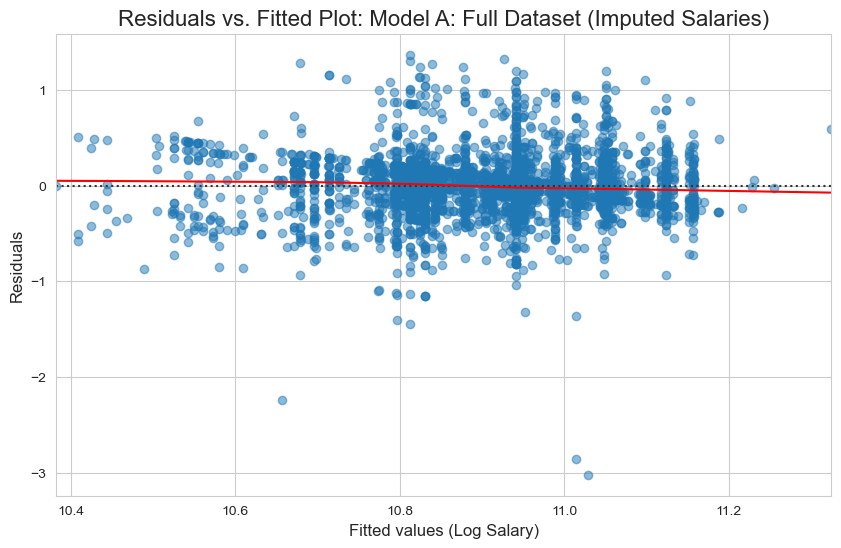

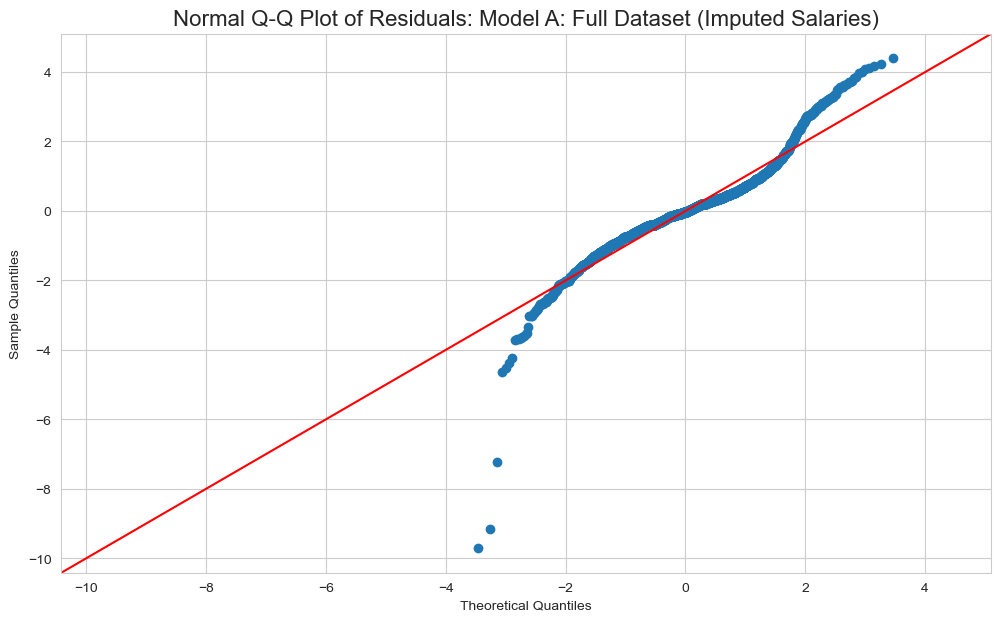


--- Benchmark Model Performance Summary ---
Model                  | R-squared | RMSE
-----------------------|-----------|---------------
OLS                    |    0.0979 | £ 20,520.69
KNN Regressor          |    0.0444 | £ 21,120.55
Random Forest Regressor|    0.0717 | £ 20,815.88


Displaying the top 12 statistically significant features for Model A: Full Dataset (Imputed Salaries) (p < 0.05):


,Feature,Salary Impact in %,P-Value,Significance
34,seniority_Senior,46.10%,0.0000,***
32,seniority_Manager/Director,45.31%,0.0000,***
33,seniority_Mid-Level,31.01%,0.0000,***
25,kmeans_job_archetype_AI Strategist,25.02%,0.0000,***
28,kmeans_job_archetype_Cloud & Data Engineer,20.88%,0.0000,***
29,kmeans_job_archetype_Machine Learning & AI Specialist,20.88%,0.0000,***
15,region_London,15.70%,0.0000,***
27,kmeans_job_archetype_Classic Data Scientist (Stats & Modeling Focus),14.45%,0.0000,***
31,kmeans_job_archetype_SQL Developer,13.28%,0.0000,***
30,kmeans_job_archetype_Noise / General Business Role,12.42%,0.0000,***


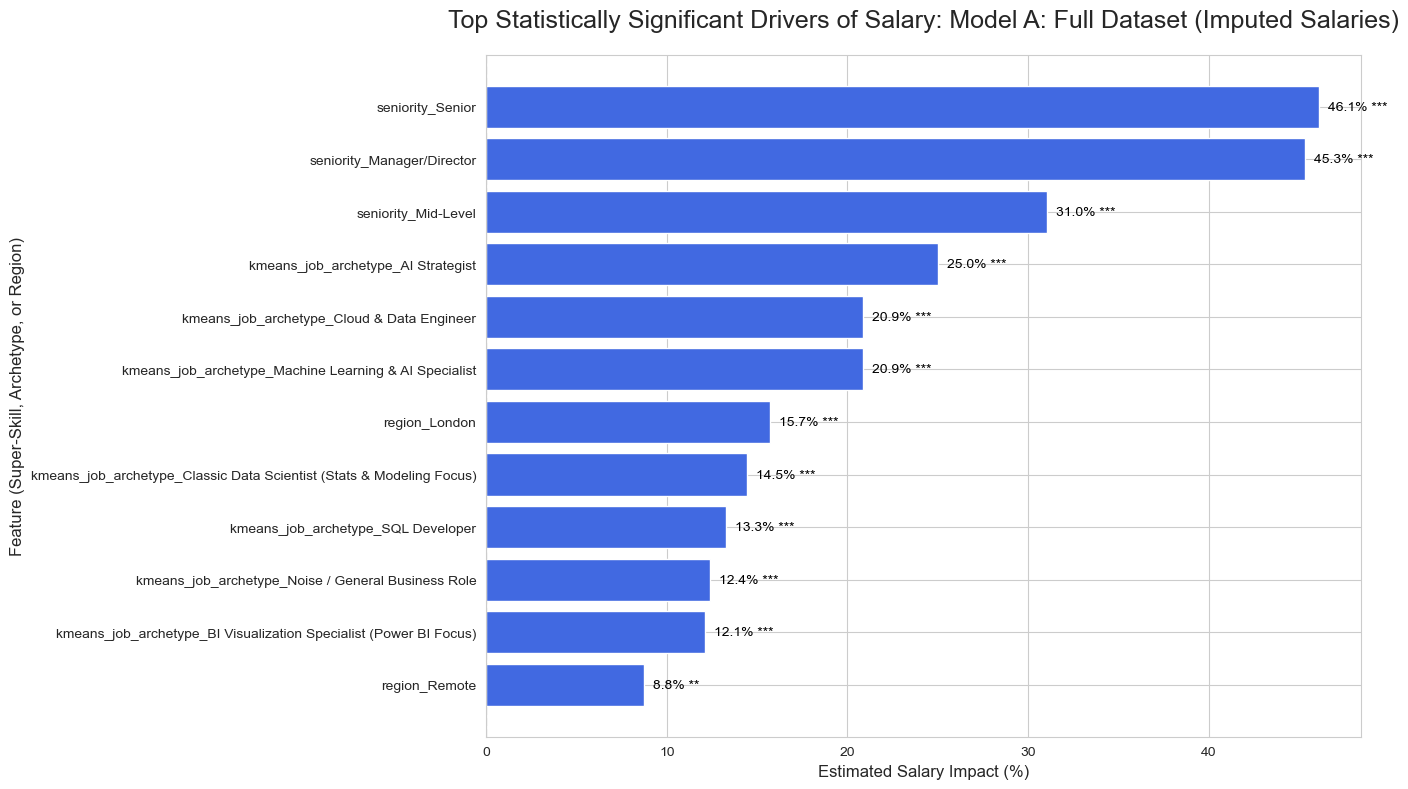

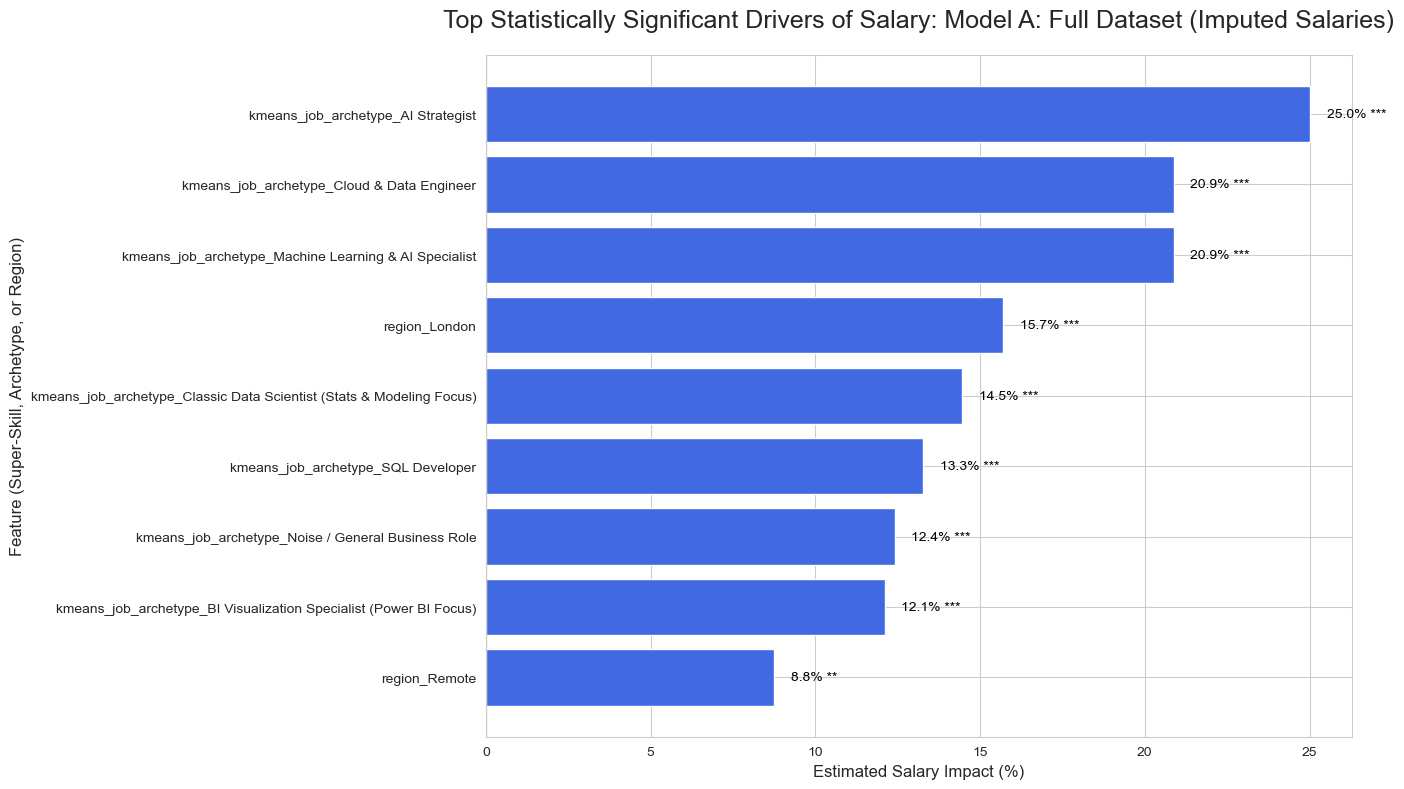

In [14]:
# Model A: Naive Model (With Noise + imputed Salary Data)
run_and_analyse_regression(df_with_noise, "Model A: Full Dataset (Imputed Salaries)")

RUNNING ANALYSIS FOR: MODEL B: SENSITIVITY (FULL DATASET, NO SALARY IMPUTATION)

--- OLS Model Summary: Model B: Sensitivity (Full Dataset, No Salary Imputation) ---
                               OLS Regression Results                               
Dep. Variable:     median_annual_salary_gbp   R-squared:                       0.232
Model:                                  OLS   Adj. R-squared:                  0.219
Method:                       Least Squares   F-statistic:                     17.15
Date:                      Fri, 15 Aug 2025   Prob (F-statistic):           5.61e-87
Time:                              00:33:22   Log-Likelihood:                -818.96
No. Observations:                      1964   AIC:                             1708.
Df Residuals:                          1929   BIC:                             1903.
Df Model:                                34                                         
Covariance Type:                  nonrobust                          

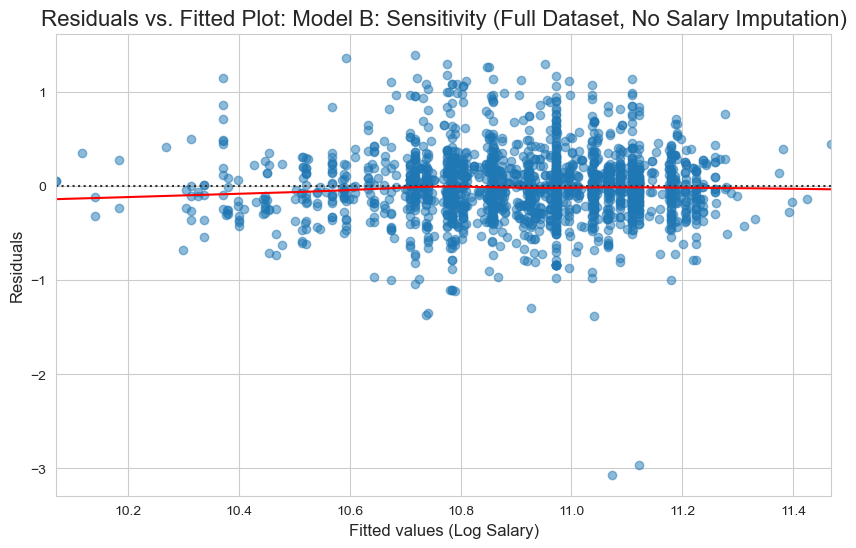

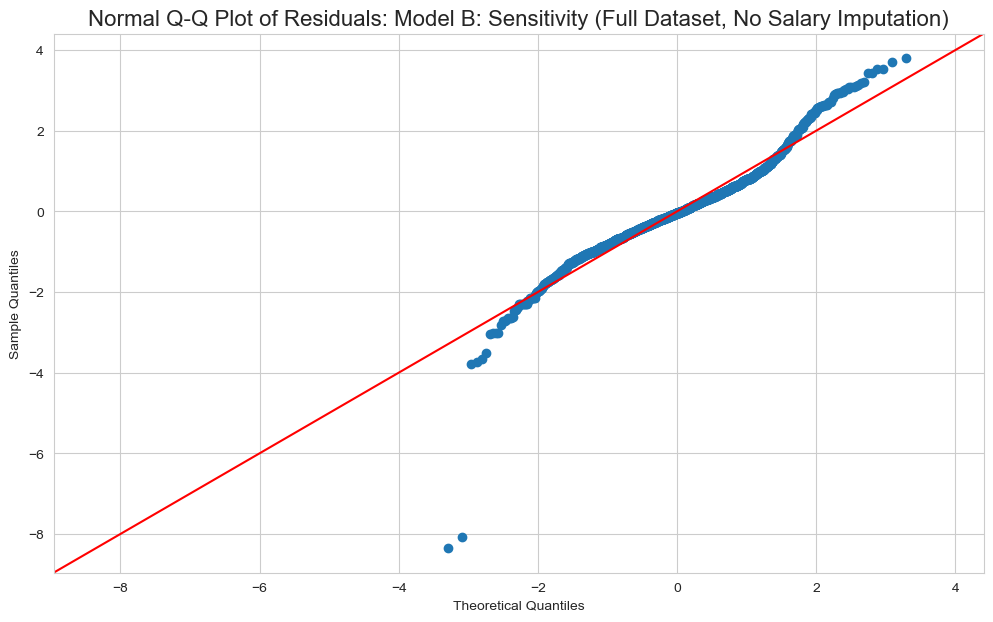


--- Benchmark Model Performance Summary ---
Model                  | R-squared | RMSE
-----------------------|-----------|---------------
OLS                    |    0.1531 | £ 26,039.78
KNN Regressor          |    0.0860 | £ 27,050.33
Random Forest Regressor|    0.1108 | £ 26,682.12


Displaying the top 12 statistically significant features for Model B: Sensitivity (Full Dataset, No Salary Imputation) (p < 0.05):


,Feature,Salary Impact in %,P-Value,Significance
32,seniority_Manager/Director,74.11%,0.0000,***
34,seniority_Senior,72.08%,0.0000,***
33,seniority_Mid-Level,49.91%,0.0000,***
28,kmeans_job_archetype_Cloud & Data Engineer,41.37%,0.0000,***
25,kmeans_job_archetype_AI Strategist,36.58%,0.0000,***
27,kmeans_job_archetype_Classic Data Scientist (Stats & Modeling Focus),31.37%,0.0000,***
29,kmeans_job_archetype_Machine Learning & AI Specialist,30.43%,0.0000,***
31,kmeans_job_archetype_SQL Developer,29.95%,0.0000,***
15,region_London,25.93%,0.0000,***
30,kmeans_job_archetype_Noise / General Business Role,21.64%,0.0000,***


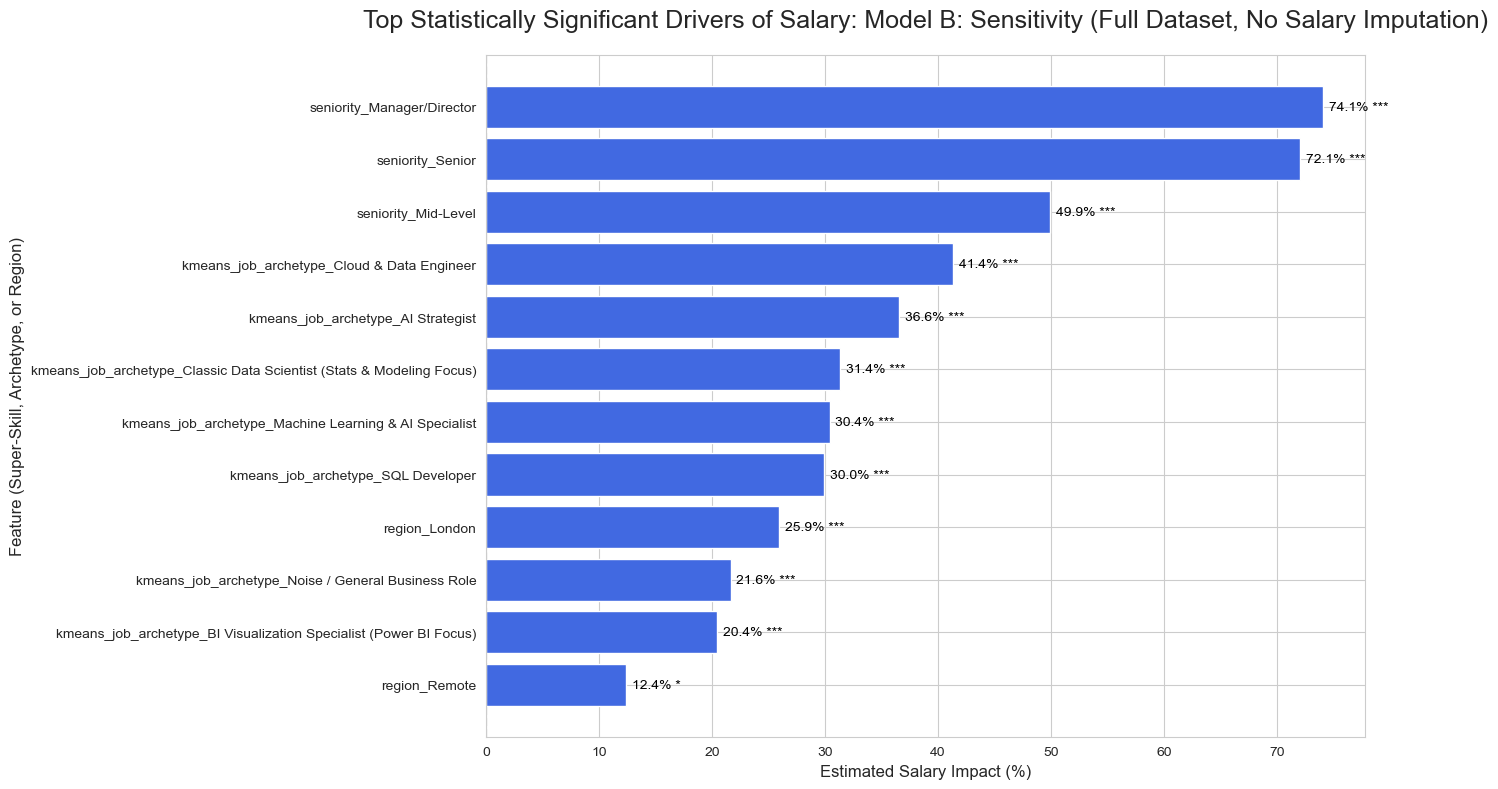

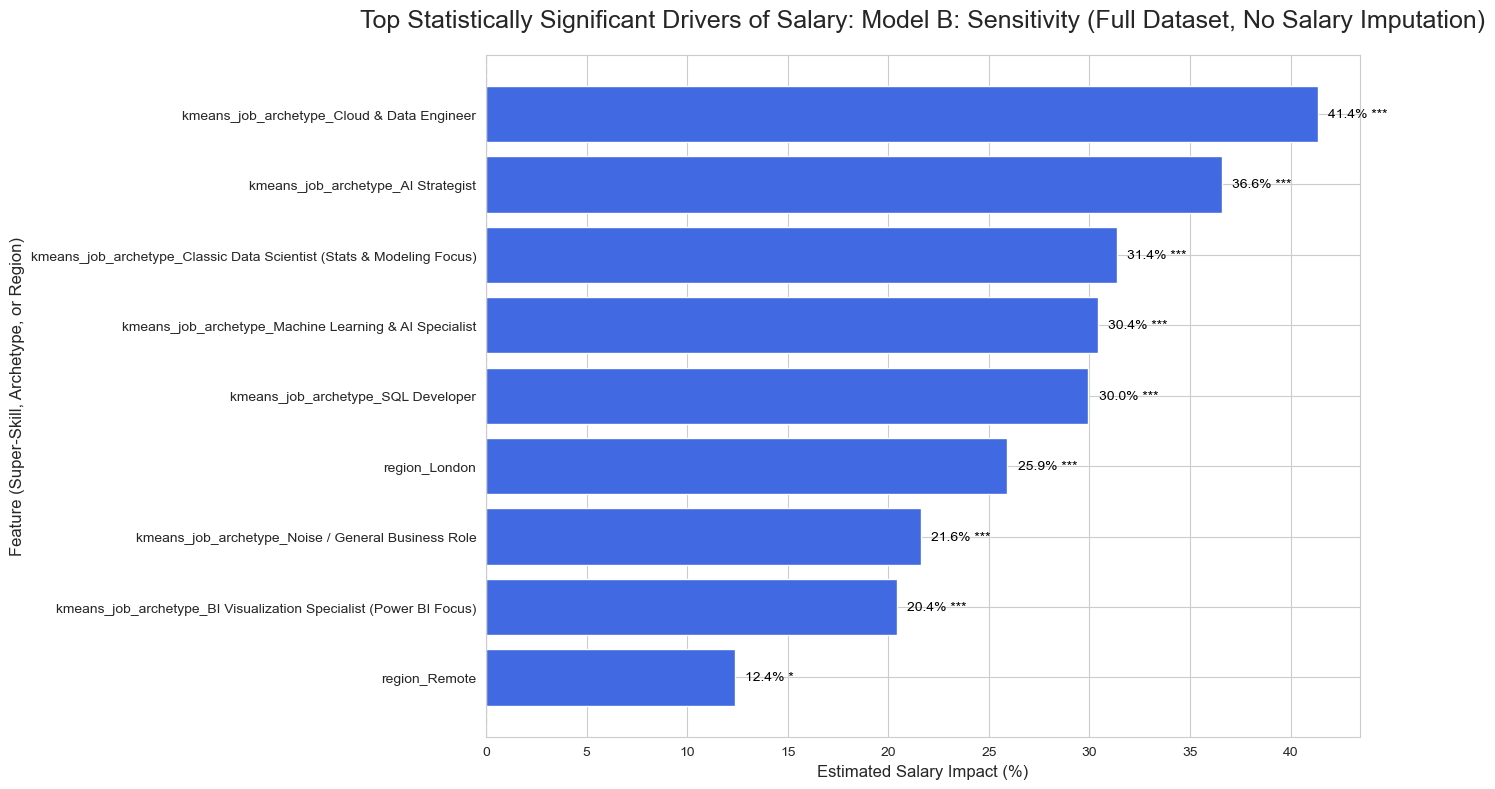

In [15]:
# Model B: Sensitivity analysis for Naive Model (With Noise, No Salary Imputation)
df_with_noise_original_salary = df_with_noise[df_with_noise['is_salary_imputed'] == False].copy()
run_and_analyse_regression(df_with_noise_original_salary, "Model B: Sensitivity (Full Dataset, No Salary Imputation)")

***
# Filtered Dataset (excluding Noise / General Business Role) Regression & Sensitivity Analysis

RUNNING ANALYSIS FOR: MODEL C: NOISE EXCLUDED DATASET (IMPUTED SALARIES)

--- OLS Model Summary: Model C: Noise Excluded Dataset (Imputed Salaries) ---
                               OLS Regression Results                               
Dep. Variable:     median_annual_salary_gbp   R-squared:                       0.205
Model:                                  OLS   Adj. R-squared:                  0.193
Method:                       Least Squares   F-statistic:                     17.15
Date:                      Fri, 15 Aug 2025   Prob (F-statistic):           3.29e-86
Time:                              00:33:23   Log-Likelihood:                -476.96
No. Observations:                      2225   AIC:                             1022.
Df Residuals:                          2191   BIC:                             1216.
Df Model:                                33                                         
Covariance Type:                  nonrobust                                        

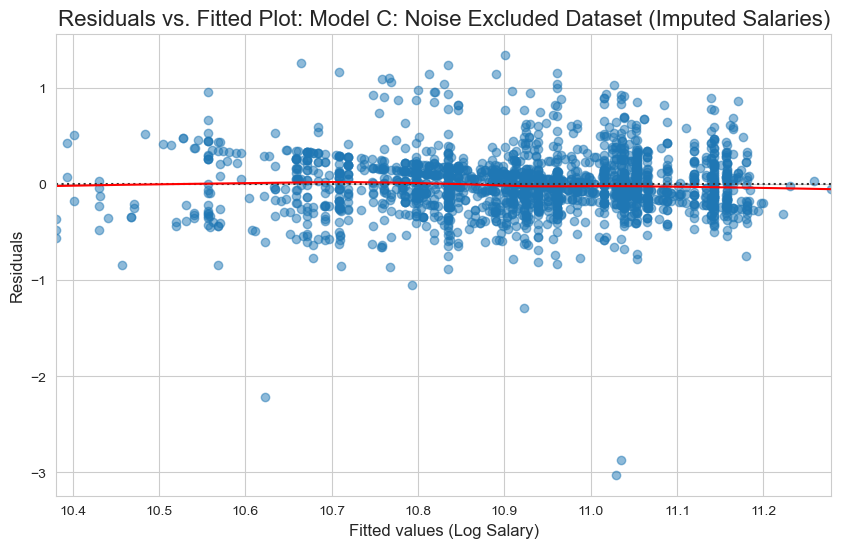

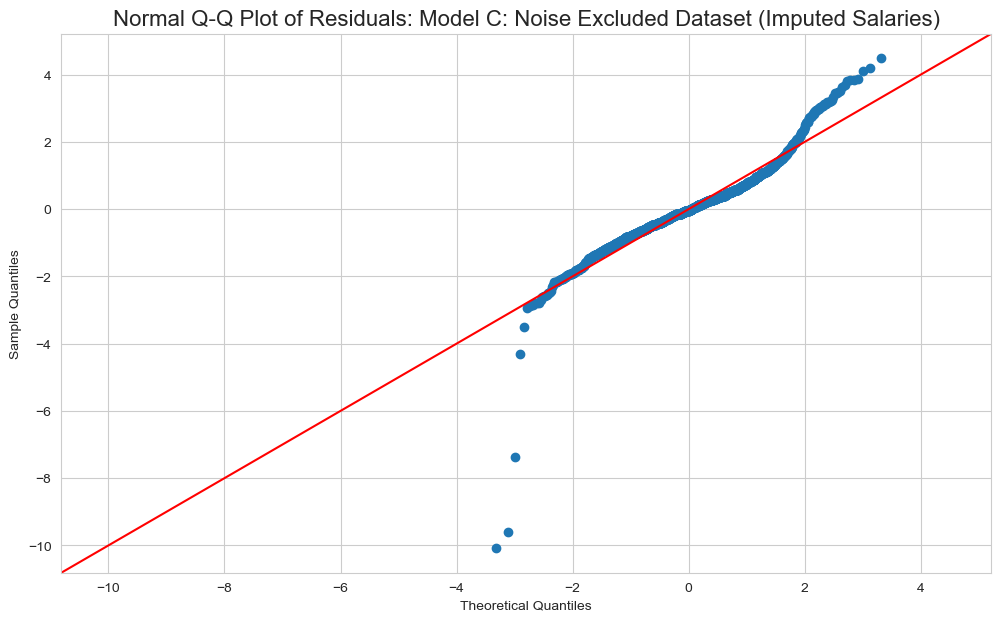


--- Benchmark Model Performance Summary ---
Model                  | R-squared | RMSE
-----------------------|-----------|---------------
OLS                    |    0.0380 | £ 21,128.87
KNN Regressor          |   -0.1595 | £ 23,196.60
Random Forest Regressor|   -0.0288 | £ 21,849.84


Displaying the top 11 statistically significant features for Model C: Noise Excluded Dataset (Imputed Salaries) (p < 0.05):


,Feature,Salary Impact in %,P-Value,Significance
31,seniority_Manager/Director,49.91%,0.0000,***
33,seniority_Senior,46.50%,0.0000,***
32,seniority_Mid-Level,31.99%,0.0000,***
25,kmeans_job_archetype_AI Strategist,24.54%,0.0000,***
29,kmeans_job_archetype_Machine Learning & AI Specialist,22.57%,0.0000,***
28,kmeans_job_archetype_Cloud & Data Engineer,22.22%,0.0000,***
15,region_London,19.26%,0.0000,***
27,kmeans_job_archetype_Classic Data Scientist (Stats & Modeling Focus),16.07%,0.0000,***
30,kmeans_job_archetype_SQL Developer,13.53%,0.0000,***
20,region_Scotland,10.49%,0.0299,*


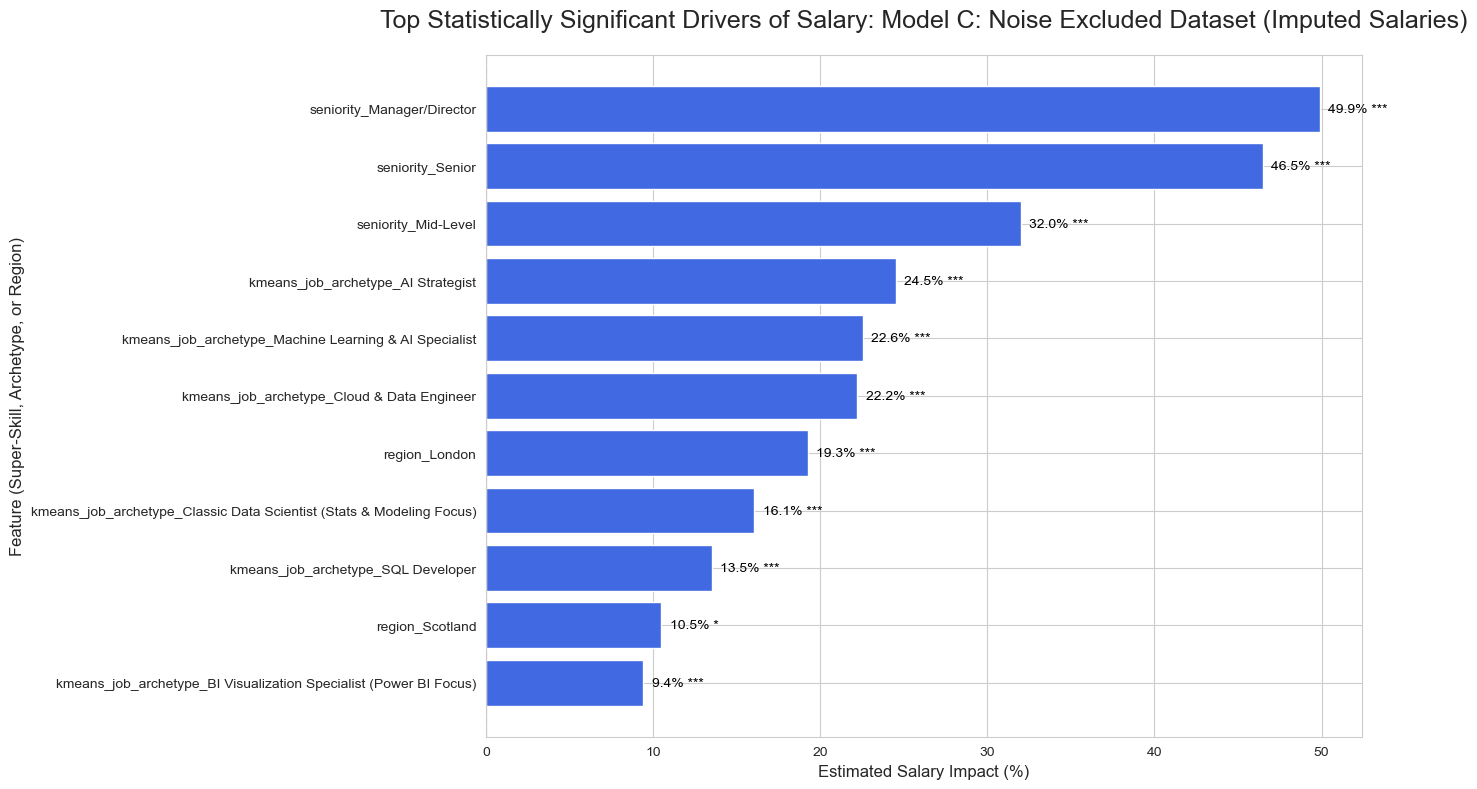

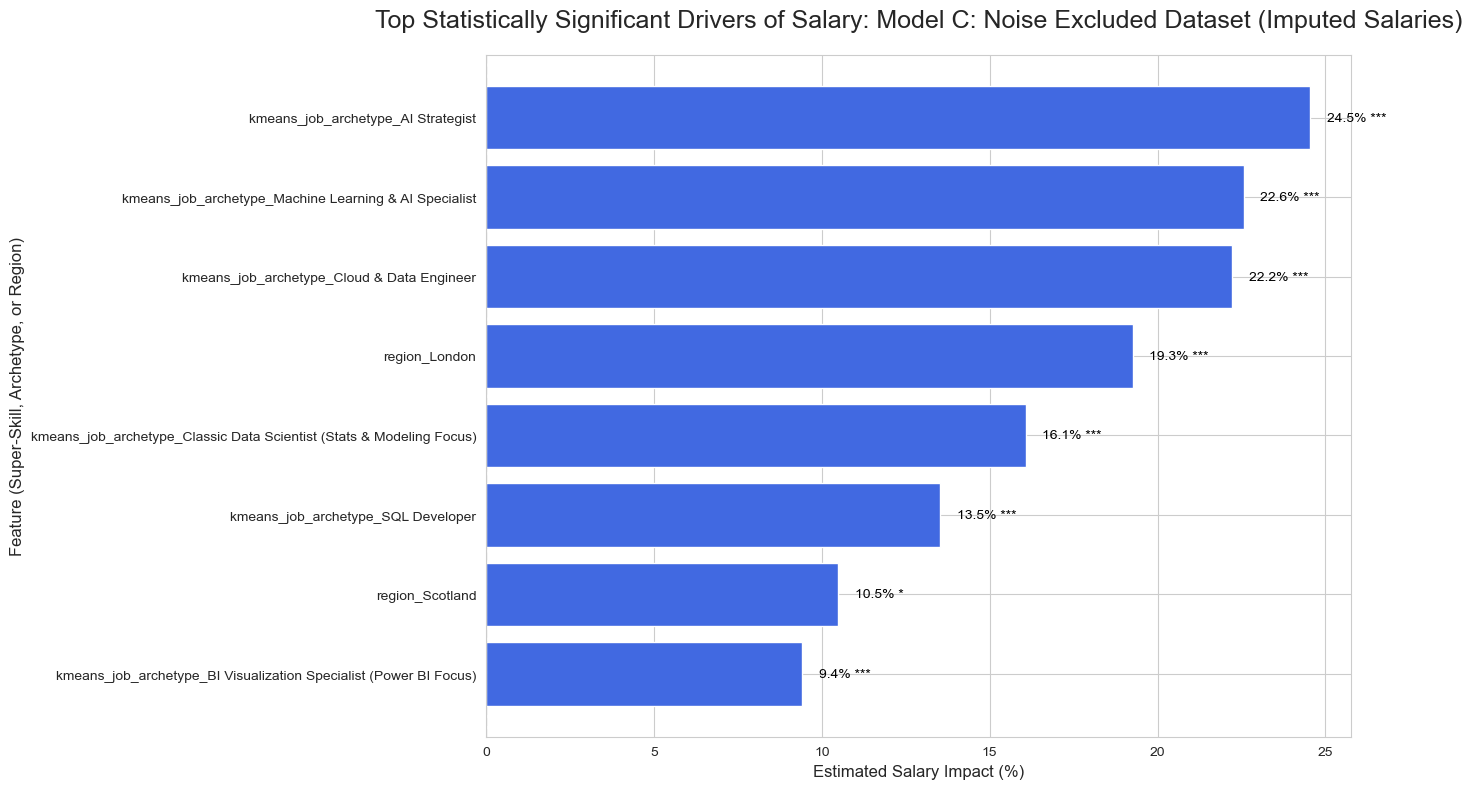

In [19]:
# Model C: Main Model (No Noise, All Data)
run_and_analyse_regression(df_no_noise, "Model C: Noise Excluded Dataset (Imputed Salaries)")

RUNNING ANALYSIS FOR: MODEL D: SENSITIVITY (EXCLUDING NOISE, NO IMPUTED SALARIES)

--- OLS Model Summary: Model D: Sensitivity (Excluding Noise, No imputed Salaries) ---
                               OLS Regression Results                               
Dep. Variable:     median_annual_salary_gbp   R-squared:                       0.293
Model:                                  OLS   Adj. R-squared:                  0.273
Method:                       Least Squares   F-statistic:                     14.58
Date:                      Fri, 15 Aug 2025   Prob (F-statistic):           3.60e-66
Time:                              00:33:24   Log-Likelihood:                -431.41
No. Observations:                      1196   AIC:                             930.8
Df Residuals:                          1162   BIC:                             1104.
Df Model:                                33                                         
Covariance Type:                  nonrobust                      

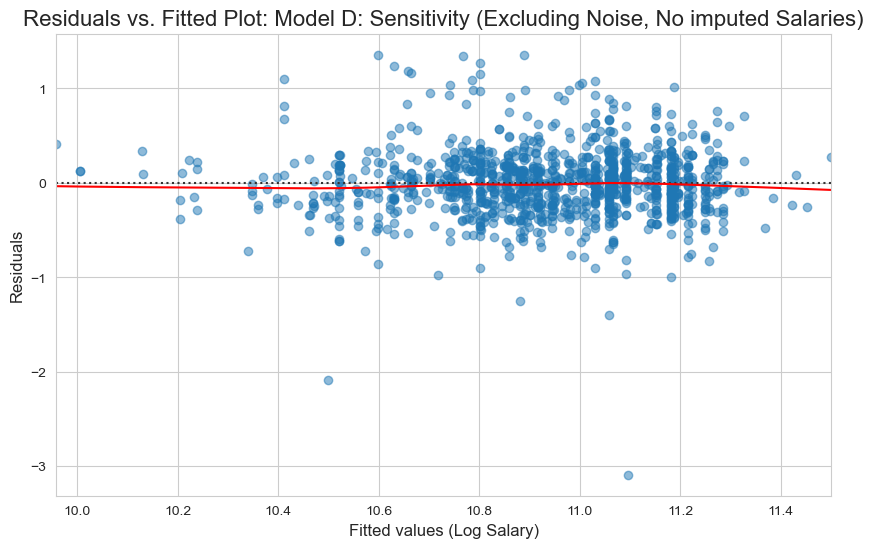

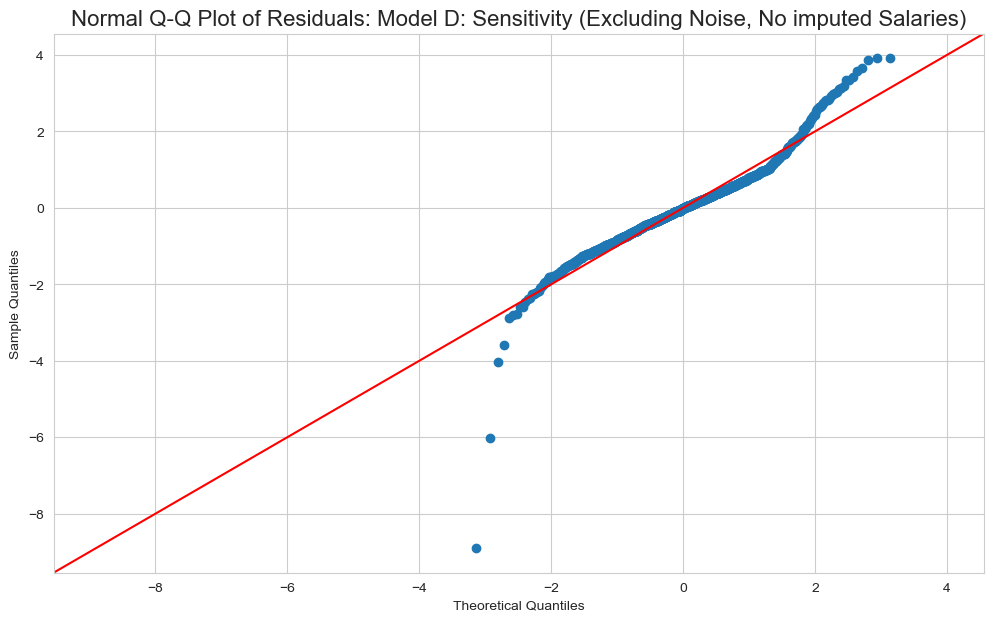


--- Benchmark Model Performance Summary ---
Model                  | R-squared | RMSE
-----------------------|-----------|---------------
OLS                    |    0.1880 | £ 22,016.41
KNN Regressor          |    0.0338 | £ 24,017.10
Random Forest Regressor|    0.0997 | £ 23,182.38


Displaying the top 11 statistically significant features for Model D: Sensitivity (Excluding Noise, No imputed Salaries) (p < 0.05):


,Feature,Salary Impact in %,P-Value,Significance
31,seniority_Manager/Director,78.90%,0.0000,***
33,seniority_Senior,66.91%,0.0000,***
32,seniority_Mid-Level,47.75%,0.0000,***
28,kmeans_job_archetype_Cloud & Data Engineer,41.82%,0.0000,***
25,kmeans_job_archetype_AI Strategist,33.83%,0.0000,***
29,kmeans_job_archetype_Machine Learning & AI Specialist,29.34%,0.0000,***
30,kmeans_job_archetype_SQL Developer,25.83%,0.0000,***
27,kmeans_job_archetype_Classic Data Scientist (Stats & Modeling Focus),23.38%,0.0005,***
15,region_London,22.82%,0.0002,***
26,kmeans_job_archetype_BI Visualization Specialist (Power BI Focus),15.41%,0.0005,***


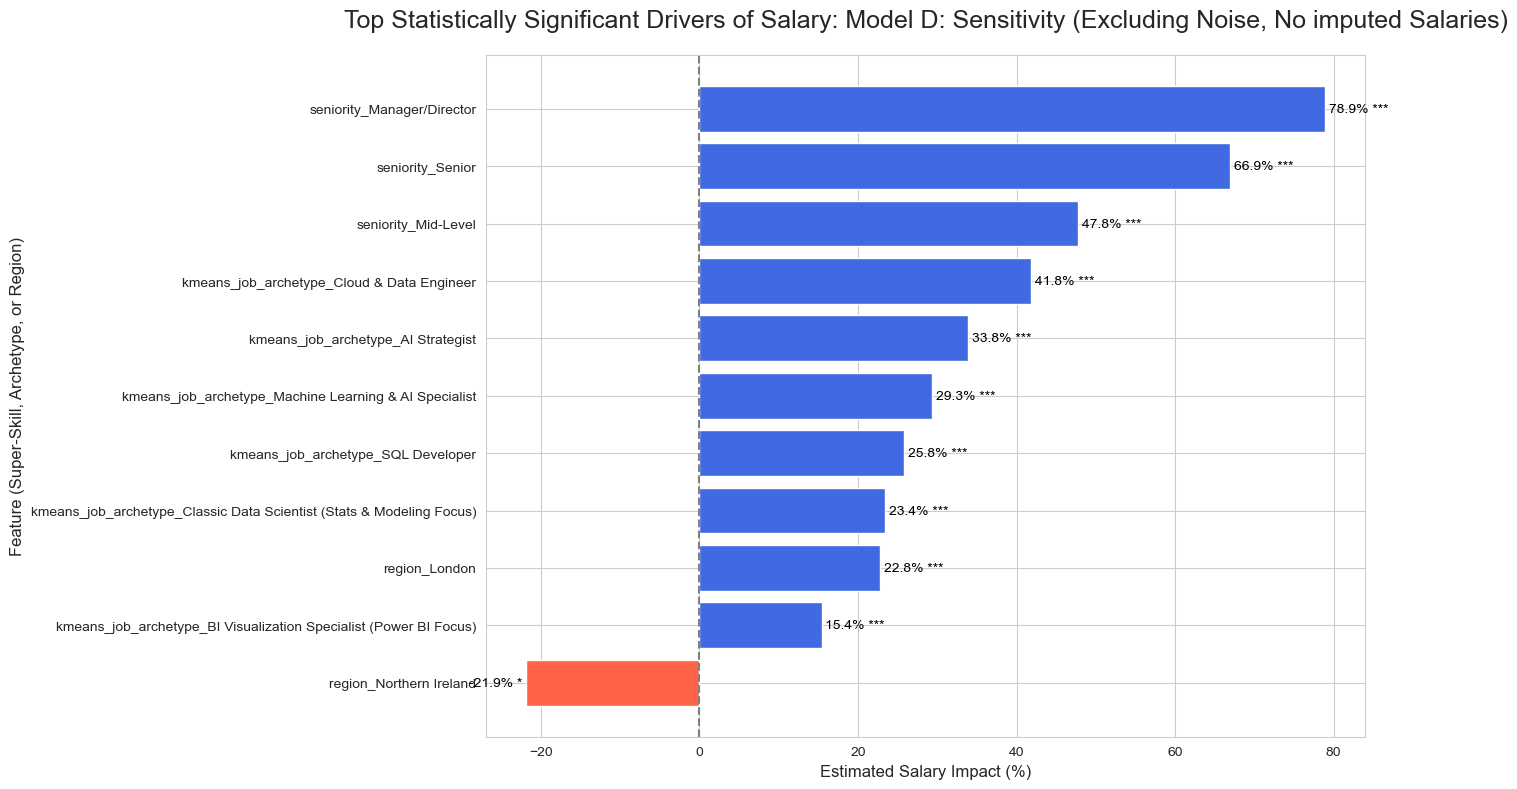

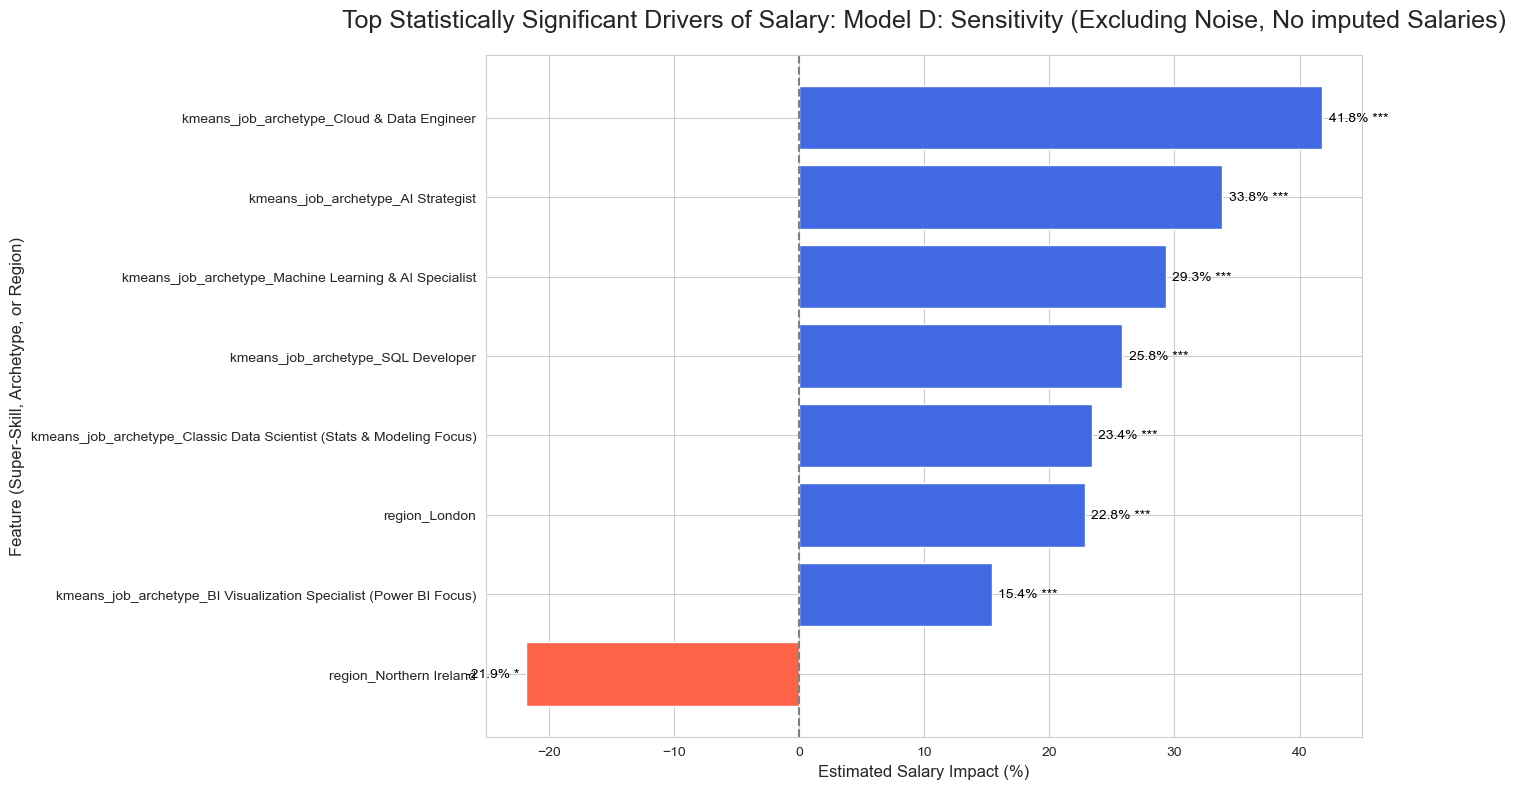

In [20]:
# Model D: Sensitivity for Main Model (No Noise, Original Salaries Only)
df_no_noise_original_salary = df_no_noise[df_no_noise['is_salary_imputed'] == False].copy()
run_and_analyse_regression(df_no_noise_original_salary, "Model D: Sensitivity (Excluding Noise, No imputed Salaries)")

***
# Final Model (C&D) Regression Results Table (for Results Section):

In [27]:
def run_regression(df, model_name):
    """
    Takes a dataframe, runs the OLS regression, and returns the fitted model.
    """  
    # --- Prepare Data ---
    TARGET_VARIABLE = 'median_annual_salary_gbp'
    X = df.drop(columns=[TARGET_VARIABLE, 'is_salary_imputed'])
    X = X.astype(int)
    y = np.log(df[TARGET_VARIABLE])
    
    # --- Train-Test Split ---
    X_train, X_test, y_train_log, y_test_log = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # --- Fit OLS Model ---
    X_train_const = sm.add_constant(X_train)
    ols_model = sm.OLS(y_train_log, X_train_const).fit()
    
    print(f"'{model_name}' fitted successfully.\n")
    return ols_model

In [29]:
model_a = None
model_b = None
model_c = None
model_d = None

In [31]:
# Model A: Main Model (No Noise, All Data)
model_a = run_regression(df_with_noise, "Model A: Full Dataset (Imputed Salaries)")

'Model A: Full Dataset (Imputed Salaries)' fitted successfully.



In [33]:
# Model A: Main Model (No Noise, All Data)
model_b = run_regression(df_with_noise_original_salary, "Model B: Sensitivity (Full Dataset, No Salary Imputation)")

'Model B: Sensitivity (Full Dataset, No Salary Imputation)' fitted successfully.



In [35]:
# Model C: Main Model (No Noise, All Data)
model_c = run_regression(df_no_noise, "Model C: No Noise (Imputed Salaries)")

'Model C: No Noise (Imputed Salaries)' fitted successfully.



In [37]:
# Model D: Sensitivity Analysis for Main Model (No Noise, Non-imputed Salaries Only)
model_d = run_regression(df_no_noise_original_salary, "Model D: No Noise (Sensitivity)")

'Model D: No Noise (Sensitivity)' fitted successfully.



In [39]:
# ==============================================================================
# --- Create Regression Results Table for Model C & D ---
# ==============================================================================

import statsmodels.api as sm
from stargazer.stargazer import Stargazer
from IPython.core.display import HTML

# Set plot style
sns.set_style('whitegrid')
plt.rc('figure', figsize=(12, 7))

# Check if the models were created successfully before proceeding
if model_c and model_d:
    print("\n" + "="*80)
    print("GENERATING FINAL REGRESSION TABLE")
    print("="*80)

    # Instantiate Stargazer with the two key models
    stargazer = Stargazer([model_c, model_d])

    # --- Customize the Table ---
    # Set the column titles
    stargazer.custom_columns(['Model C (Main)', 'Model D (Sensitivity)'], [1, 1])
    stargazer.title('OLS Regression Results for Log(Salary)')
    
    # Define order of variables for a thematic layout
    variable_order = [
        # --- Job Archetypes (Primary Findings) ---
        "kmeans_job_archetype_Cloud & Data Engineer",
        "kmeans_job_archetype_Machine Learning & AI Specialist",
        "kmeans_job_archetype_AI Strategist",
        "kmeans_job_archetype_Classic Data Scientist (Stats & Modeling Focus)",
        "kmeans_job_archetype_SQL Developer",
        "kmeans_job_archetype_BI Visualization Specialist (Power BI Focus)",
    
        # --- Super-Skills (Secondary Findings from PCA) ---
        "SuperSkill_Basic_Data_Science",
        "SuperSkill_BI_DataViz",
        "SuperSkill_Statistical_Analysis_Reporting",
        "SuperSkill_Cloud-Enabled_AI_BI",
        "SuperSkill_SQL_Analytics_&_Automation",
        "SuperSkill_AI_Cloud_Excel",
        "SuperSkill_Cloud_Augmented_Analysis",
        "SuperSkill_Cloud_Analytics_Econometrics",
        "SuperSkill_Python_Data_Products",
        "SuperSkill_Cloud_Engineering_MLOps",
        "SuperSkill_Analytics_Engineering_&_MLOps",
        "SuperSkill_R_StatScience_&_BI",
    
        # --- Seniority Controls ---
        "seniority_Manager/Director",
        "seniority_Senior",
        "seniority_Mid-Level",
    
        # --- Regional Fixed Effects (Controls) ---
        "region_London",
        "region_Remote",
        "region_Scotland",
        "region_South East (England)",
        "region_East of England",
        "region_North West (England)",
        "region_South West (England)",
        "region_East Midlands (England)",
        "region_Yorkshire and The Humber",
        "region_North East (England)",
        "region_Wales",
        "region_Northern Ireland"
    ]

    # Apply the order to the stargazer table.
    # This will also implicitly keep ONLY the variables listed above.
    stargazer.covariate_order(variable_order)
    
    # Add custom notes at the bottom
    stargazer.add_custom_notes([
        'Significance: *** p < 0.001, ** p < 0.01, * p < 0.05.',
        'Dependent variable is Log(Median Annual Salary).',
        'Base categories: "Traditional Analyst", "West Midlands", "Junior".',
        'Model includes a full set of regional and Super-Skill controls.'
    ])

    # Render the table as HTML in the notebook
    display(HTML(stargazer.render_html()))

else:
    print("\nCould not generate final table because one or more models failed to run.")


GENERATING FINAL REGRESSION TABLE


***
# All Models (A-D) Regression Results Comparison Table (for Appendix):

In [44]:
# ==============================================================================
# --- Create Regression Results Table for Models A - D ---
# ==============================================================================

# Set plot style
sns.set_style('whitegrid')
plt.rc('figure', figsize=(12, 7))

# Check if the models were created successfully before proceeding
if model_a and model_b and model_c and model_d:
    print("\n" + "="*80)
    print("GENERATING ALL MODELS FINAL REGRESSION TABLE")
    print("="*80)

    # Instantiate Stargazer with all models
    stargazer = Stargazer([model_a, model_b, model_c, model_d])

    # --- Customize the Table ---
    # Set the column titles
    stargazer.custom_columns(['Model A (With Noise)', 'Model B (With Noise, Sensitivity)', 
                              'Model C (Main Model - No Noise)','Model D (Main Model - No Noise, Sensitivity)'], [1, 1, 1, 1])
    stargazer.title('OLS Regression Results for Log(Salary)')
    
    # Define order of variables for a thematic layout
    variable_order = [
        # --- Job Archetypes (Primary Findings) ---
        "kmeans_job_archetype_Cloud & Data Engineer",
        "kmeans_job_archetype_Machine Learning & AI Specialist",
        "kmeans_job_archetype_AI Strategist",
        "kmeans_job_archetype_Classic Data Scientist (Stats & Modeling Focus)",
        "kmeans_job_archetype_SQL Developer",
        "kmeans_job_archetype_BI Visualization Specialist (Power BI Focus)",
    
        # --- Super-Skills (Secondary Findings from PCA) ---
        "SuperSkill_Basic_Data_Science",
        "SuperSkill_BI_DataViz",
        "SuperSkill_Statistical_Analysis_Reporting",
        "SuperSkill_Cloud-Enabled_AI_BI",
        "SuperSkill_SQL_Analytics_&_Automation",
        "SuperSkill_AI_Cloud_Excel",
        "SuperSkill_Cloud_Augmented_Analysis",
        "SuperSkill_Cloud_Analytics_Econometrics",
        "SuperSkill_Python_Data_Products",
        "SuperSkill_Cloud_Engineering_MLOps",
        "SuperSkill_Analytics_Engineering_&_MLOps",
        "SuperSkill_R_StatScience_&_BI",
    
        # --- Seniority Controls ---
        "seniority_Manager/Director",
        "seniority_Senior",
        "seniority_Mid-Level",
    
        # --- Regional Fixed Effects (Controls) ---
        "region_London",
        "region_Remote",
        "region_Scotland",
        "region_South East (England)",
        "region_East of England",
        "region_North West (England)",
        "region_South West (England)",
        "region_East Midlands (England)",
        "region_Yorkshire and The Humber",
        "region_North East (England)",
        "region_Wales",
        "region_Northern Ireland"
    ]

    # Apply the order to the stargazer table.
    # This will also implicitly keep ONLY the variables listed above.
    stargazer.covariate_order(variable_order)
    
    # Add custom notes at the bottom
    stargazer.add_custom_notes([
        'Significance: *** p < 0.001, ** p < 0.01, * p < 0.05.',
        'Dependent variable is Log(Median Annual Salary).',
        'Base categories: "Traditional Analyst", "West Midlands", "Junior".',
        'Model includes a full set of regional and Super-Skill controls.'
    ])

    # Render the table as HTML in the notebook
    display(HTML(stargazer.render_html()))

else:
    print("\nCould not generate final table because one or more models failed to run.")


GENERATING ALL MODELS FINAL REGRESSION TABLE


In [48]:
!jupyter nbconvert --to script 'IBM_master_regression_analysis_FINAL.ipynb'

[NbConvertApp] Converting notebook IBM_master_regression_analysis_FINAL.ipynb to script
[NbConvertApp] Writing 25004 bytes to IBM_master_regression_analysis_FINAL.py
